# Programming assignment 3: Optimization - Logistic Regression

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Your task

In this notebook code skeleton for performing logistic regression with gradient descent is given. 
Your task is to complete the functions where required. 
You are only allowed to use built-in Python functions, as well as any `numpy` functions. No other libraries / imports are allowed.

For numerical reasons, we actually minimize the following loss function

$$\mathcal{L}(\mathbf{w}) = \frac{1}{N} NLL(\mathbf{w}) +  \frac{1}{2}\lambda ||\mathbf{w}||^2_2$$

where $NLL(\mathbf{w})$ is the negative log-likelihood function, as defined in the lecture (see Slide 39).

## Load and preprocess the data

In this assignment we will work with the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset https://goo.gl/U2Uwz2.

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. There are 212 malignant examples and 357 benign examples.

In [25]:
X, y = load_breast_cancer(return_X_y=True)

# Add a vector of ones to the data matrix to absorb the bias term
X = np.hstack([np.ones([X.shape[0], 1]), X])

# Set the random seed so that we have reproducible experiments
np.random.seed(123)

# Split into train and test
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

## Task 1: Implement the sigmoid function 

In [26]:
def sigmoid(t):
    """
    Applies the sigmoid function elementwise to the input data.
    
    Parameters
    ----------
    t : array, arbitrary shape
        Input data.
        
    Returns
    -------
    t_sigmoid : array, arbitrary shape.
        Data after applying the sigmoid function.
    """
    
    result = 1/(1+np.exp(-t))

    return result

## Task 2: Implement the negative log likelihood

As defined in Eq. 33

In [27]:
def negative_log_likelihood(X, y, w):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    nll : float
        The negative log likelihood.
    """
    
    scores = sigmoid(np.dot(X,w))

    result = - np.sum((y * np.log(scores)) + ((1-y) * np.log(1- scores)))

    return result

### Computing the loss function $\mathcal{L}(\mathbf{w})$ (nothing to do here)

In [28]:
def compute_loss(X, y, w, lmbda):
    """
    Negative Log Likelihood of the Logistic Regression.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    lmbda : float
        L2 regularization strength.
        
    Returns
    -------
    loss : float
        Loss of the regularized logistic regression model.
    """
    # The bias term w[0] is not regularized by convention
    return negative_log_likelihood(X, y, w) / len(y) + lmbda * 0.5 * np.linalg.norm(w[1:])**2

## Task 3: Implement the gradient $\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w})$

Make sure that you compute the gradient of the loss function $\mathcal{L}(\mathbf{w})$ (not simply the NLL!)

In [29]:
def get_gradient(X, y, w, mini_batch_indices, lmbda):
    """
    Calculates the gradient (full or mini-batch) of the negative log likelilhood w.r.t. w.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
    mini_batch_indices: array, shape [mini_batch_size]
        The indices of the data points to be included in the (stochastic) calculation of the gradient.
        This includes the full batch gradient as well, if mini_batch_indices = np.arange(n_train).
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
        
    Returns
    -------
    dw : array, shape [D]
        Gradient w.r.t. w.
    """
    
    N = len(y)
    mini_batch_size = len(mini_batch_indices)

    y_pred = sigmoid(np.dot(X,w))

    # Compute the gradient of the negative log likelihood w.r.t. w
    dw = (1 / mini_batch_size) * np.dot(X[mini_batch_indices].T, y_pred[mini_batch_indices] - y[mini_batch_indices])

    # Add regularization term (excluding the bias term)
    dw[1:] += (lmbda / N) * w[1:]

    return dw

### Train the logistic regression model (nothing to do here)

In [30]:
def logistic_regression(X, y, num_steps, learning_rate, mini_batch_size, lmbda, verbose):
    """
    Performs logistic regression with (stochastic) gradient descent.
    
    Parameters
    ----------
    X : array, shape [N, D]
        (Augmented) feature matrix.
    y : array, shape [N]
        Classification targets.
    num_steps : int
        Number of steps of gradient descent to perform.
    learning_rate: float
        The learning rate to use when updating the parameters w.
    mini_batch_size: int
        The number of examples in each mini-batch.
        If mini_batch_size=n_train we perform full batch gradient descent. 
    lmbda: float
        Regularization strentgh. lmbda = 0 means having no regularization.
    verbose : bool
        Whether to print the loss during optimization.
        
    Returns
    -------
    w : array, shape [D]
        Optimal regression coefficients (w[0] is the bias term).
    trace: list
        Trace of the loss function after each step of gradient descent.
    """
    
    trace = [] # saves the value of loss every 50 iterations to be able to plot it later
    n_train = X.shape[0] # number of training instances
    
    w = np.zeros(X.shape[1]) # initialize the parameters to zeros
    
    # run gradient descent for a given number of steps
    for step in range(num_steps):
        permuted_idx = np.random.permutation(n_train) # shuffle the data
        
        # go over each mini-batch and update the paramters
        # if mini_batch_size = n_train we perform full batch GD and this loop runs only once
        for idx in range(0, n_train, mini_batch_size):
            # get the random indices to be included in the mini batch
            mini_batch_indices = permuted_idx[idx:idx+mini_batch_size]
            gradient = get_gradient(X, y, w, mini_batch_indices, lmbda)

            # update the parameters
            w = w - learning_rate * gradient
        
        # calculate and save the current loss value every 50 iterations
        if step % 50 == 0:
            loss = compute_loss(X, y, w, lmbda)
            trace.append(loss)
            # print loss to monitor the progress
            if verbose:
                print('Step {0}, loss = {1:.4f}'.format(step, loss))
    return w, trace

## Task 4: Implement the function to obtain the predictions

In [31]:
def predict(X, w):
    """
    Parameters
    ----------
    X : array, shape [N_test, D]
        (Augmented) feature matrix.
    w : array, shape [D]
        Regression coefficients (w[0] is the bias term).
        
    Returns
    -------
    y_pred : array, shape [N_test]
        A binary array of predictions.
    """
    
    return (sigmoid(np.dot(X, w)) > 0.5).astype(np.int)

### Full batch gradient descent

In [32]:
# Change this to True if you want to see loss values over iterations.
verbose = True

In [33]:
n_train = X_train.shape[0]
w_full, trace_full = logistic_regression(X_train, 
                                         y_train, 
                                         num_steps=8000, 
                                         learning_rate=1e-5, 
                                         mini_batch_size=n_train, 
                                         lmbda=0.1,
                                         verbose=verbose)

Step 0, loss = 0.7427
Step 50, loss = 0.9390
Step 100, loss = 0.5167
Step 150, loss = 0.3869
Step 200, loss = 0.3676
Step 250, loss = 0.3523
Step 300, loss = 0.3396
Step 350, loss = 0.3289
Step 400, loss = 0.3198
Step 450, loss = 0.3119
Step 500, loss = 0.3050
Step 550, loss = 0.2988
Step 600, loss = 0.2933


Step 650, loss = 0.2884
Step 700, loss = 0.2839
Step 750, loss = 0.2799
Step 800, loss = 0.2762
Step 850, loss = 0.2728
Step 900, loss = 0.2697
Step 950, loss = 0.2669
Step 1000, loss = 0.2642
Step 1050, loss = 0.2617
Step 1100, loss = 0.2594
Step 1150, loss = 0.2573
Step 1200, loss = 0.2553
Step 1250, loss = 0.2535
Step 1300, loss = 0.2517
Step 1350, loss = 0.2501
Step 1400, loss = 0.2485
Step 1450, loss = 0.2471
Step 1500, loss = 0.2457
Step 1550, loss = 0.2444
Step 1600, loss = 0.2432
Step 1650, loss = 0.2420
Step 1700, loss = 0.2409
Step 1750, loss = 0.2399
Step 1800, loss = 0.2389
Step 1850, loss = 0.2379
Step 1900, loss = 0.2370
Step 1950, loss = 0.2362
Step 2000, loss = 0.2353
Step 2050, loss = 0.2346
Step 2100, loss = 0.2338
Step 2150, loss = 0.2331
Step 2200, loss = 0.2324
Step 2250, loss = 0.2318
Step 2300, loss = 0.2311
Step 2350, loss = 0.2305
Step 2400, loss = 0.2300
Step 2450, loss = 0.2294
Step 2500, loss = 0.2289
Step 2550, loss = 0.2284
Step 2600, loss = 0.2279
Step 26

In [34]:
n_train = X_train.shape[0]
w_minibatch, trace_minibatch = logistic_regression(X_train, 
                                                   y_train, 
                                                   num_steps=8000, 
                                                   learning_rate=1e-5, 
                                                   mini_batch_size=50, 
                                                   lmbda=0.1,
                                                   verbose=verbose)

Step 0, loss = 1.3392
Step 50, loss = 0.3213
Step 100, loss = 0.2859
Step 150, loss = 0.2554
Step 200, loss = 0.2582
Step 250, loss = 0.2406
Step 300, loss = 0.2286
Step 350, loss = 0.2271
Step 400, loss = 0.2221
Step 450, loss = 0.2237
Step 500, loss = 0.2220
Step 550, loss = 0.2308
Step 600, loss = 0.2157
Step 650, loss = 0.2167
Step 700, loss = 0.2144
Step 750, loss = 0.2179
Step 800, loss = 0.2121
Step 850, loss = 0.2341
Step 900, loss = 0.2110
Step 950, loss = 0.2139
Step 1000, loss = 0.2104
Step 1050, loss = 0.2162
Step 1100, loss = 0.2093
Step 1150, loss = 0.2085
Step 1200, loss = 0.2090
Step 1250, loss = 0.2113
Step 1300, loss = 0.2100
Step 1350, loss = 0.2070
Step 1400, loss = 0.2077
Step 1450, loss = 0.2064
Step 1500, loss = 0.2060
Step 1550, loss = 0.2092
Step 1600, loss = 0.2165
Step 1650, loss = 0.2064
Step 1700, loss = 0.2131
Step 1750, loss = 0.2069
Step 1800, loss = 0.2048
Step 1850, loss = 0.2099
Step 1900, loss = 0.2038
Step 1950, loss = 0.2246
Step 2000, loss = 0.205

Our reference solution produces, but don't worry if yours is not exactly the same. 

    Full batch: accuracy: 0.9240, f1_score: 0.9384
    Mini-batch: accuracy: 0.9415, f1_score: 0.9533

In [35]:
y_pred_full = predict(X_test, w_full)
y_pred_minibatch = predict(X_test, w_minibatch)

print('Full batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_full), f1_score(y_test, y_pred_full)))
print('Mini-batch: accuracy: {:.4f}, f1_score: {:.4f}'
      .format(accuracy_score(y_test, y_pred_minibatch), f1_score(y_test, y_pred_minibatch)))

Full batch: accuracy: 0.9240, f1_score: 0.9384
Mini-batch: accuracy: 0.9415, f1_score: 0.9533


/var/folders/fp/y9nmf2t50p3_vyfsdjw2tclh0000gn/T/ipykernel_2460/420433949.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (sigmoid(np.dot(X, w)) > 0.5).astype(np.int)


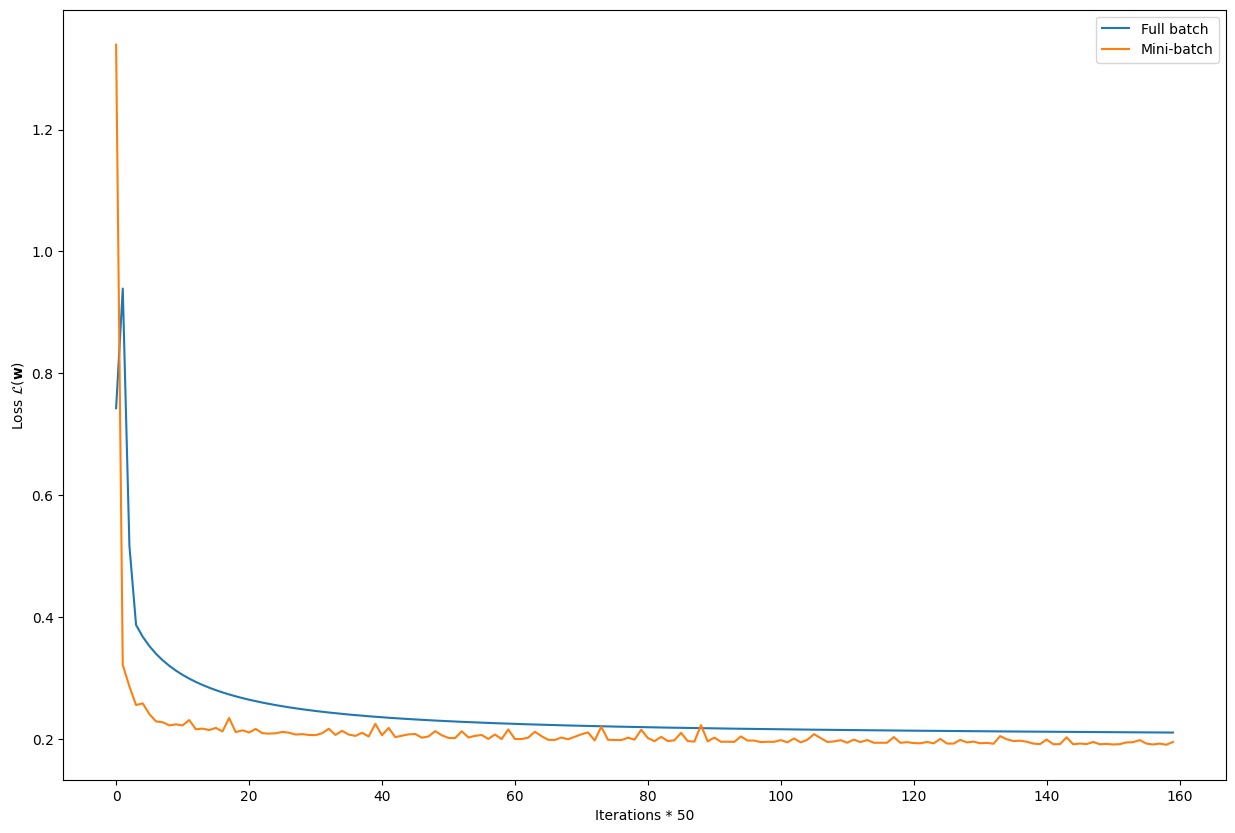

In [36]:
plt.figure(figsize=[15, 10])
plt.plot(trace_full, label='Full batch')
plt.plot(trace_minibatch, label='Mini-batch')
plt.xlabel('Iterations * 50')
plt.ylabel('Loss $\mathcal{L}(\mathbf{w})$')
plt.legend()
plt.show()